# CS 1164 Machine Learning - Final Project

Group Members:
- Alexander Diaz
- Gavin Wieckowski

## (0) Import required dependencies for the project

In [12]:
# Setup Dependencies
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

# PCA Dependencies
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print(keras.__version__)
print(tf.__version__)

2.15.0
2.15.0


## (1) Load And Clean Data

In [13]:
# import data/star_classification.csv
data = pd.read_csv('data/star_classification.csv')
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [14]:
# Clean the data
data = data.dropna()
data = data.drop_duplicates()
cdata = data.drop(['class'], axis=1) # drop class column so we can predict it later
cdata.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0.116123,6121,56187,842


In [15]:
# Create numeric classes for the class column
# useful for plotting
label_encoder = LabelEncoder()
numeric_classes = label_encoder.fit_transform(data['class'])

## (2) Dimensionality Reduction

### Data described
[Stellar Classification Dataset](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)


The dataset chosen for this project is used to predict stellar objects based on around 18 different attributes. We chose to predict the class of the object so that field was removed from dataset so that we can predict it later.

This list is pulled directly from the Kaggle page about the datasheet.
1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

In [16]:
# Describe your data with a short text paragraph: describe the domain, number and type of attributes, number of instances, and anything else that seems to be relevant.

# instances
print("Number of instances: ", data.shape[0])

# attributes
print("\nNumber of attributes: ", data.shape[1])

# domain
print("\nDomain: ", data.columns)

# type of attributes
print("\nType of attributes: ", data.dtypes)

# relevant information
print("\nRelevant information: ", data.describe())

Number of instances:  100000

Number of attributes:  18

Domain:  Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

Type of attributes:  obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object

Relevant information:               obj_ID          alpha          delta              u  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   1.237665e+18     177.629117      24.135305      21.980468   
std    8.438560e+12      96.502241      19.644665 

### Preparing for PCA
To get a better idea of how many components we should use for our dimensionality reduction there are these two graphs that will help to visualize the data.
With these two plots we are able to determine what number of components we should use to retain an approximate 95% of variance.

1. Scree Plot
- Visualizes the eigenvalues of the components.
- Where the slope of the curve flattens is a decent cutoff point.

2. Explained Variance Ratio
- Indicates the proportion of the dataset's total variance explained by each component.
- By plotting these values we can determine the number of components to explain a desired amount of total variance.

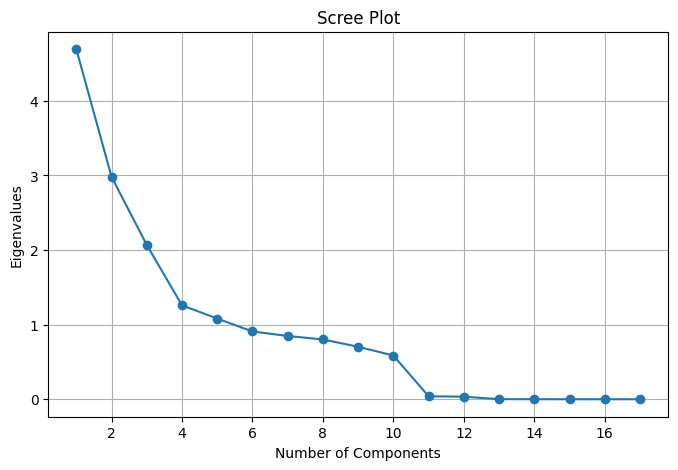

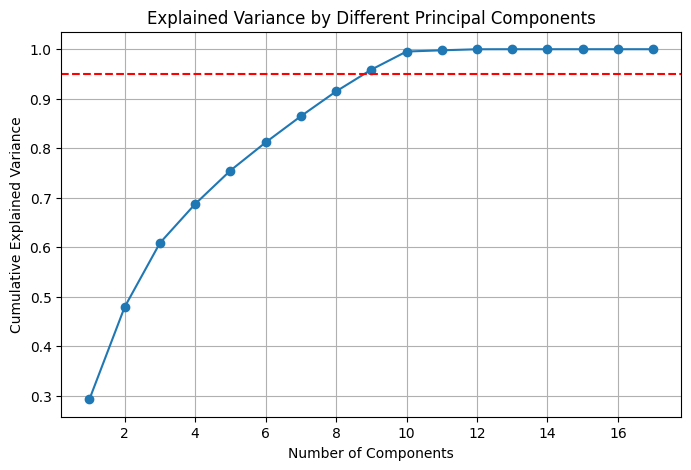

In [17]:
# Start by determining the number of principal components to use
# to retain 95% of the variance

# Standardize the Data
scaler = StandardScaler()
scaler.fit(cdata)
scaled_data = scaler.transform(cdata)

# Perform PCA without reducing dimensionality to compute full variance
pca = PCA()
pca.fit(scaled_data)

# Plot the explained variance by each component
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Calculate cumulative variance explained by all components
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--')  # Line at 95% variance
plt.grid(True)
plt.show()

### Performing PCA
We chose to do PCA decomposition for our dimensionality reduction.

Based on the data above, we should be permforming PCA with around 8-9 components to retain our 95% variance.

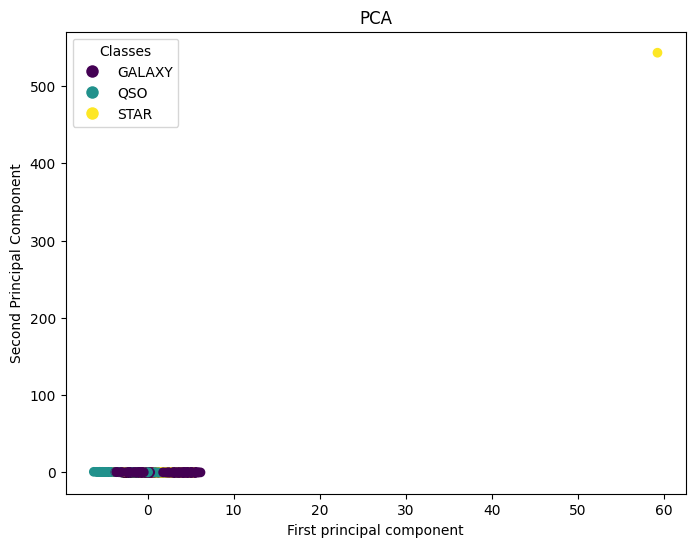

[0.29323714 0.18625784 0.12923462 0.07864501 0.06756852 0.05676373
 0.05299149 0.05006391 0.04396882]
0.9587310928680357


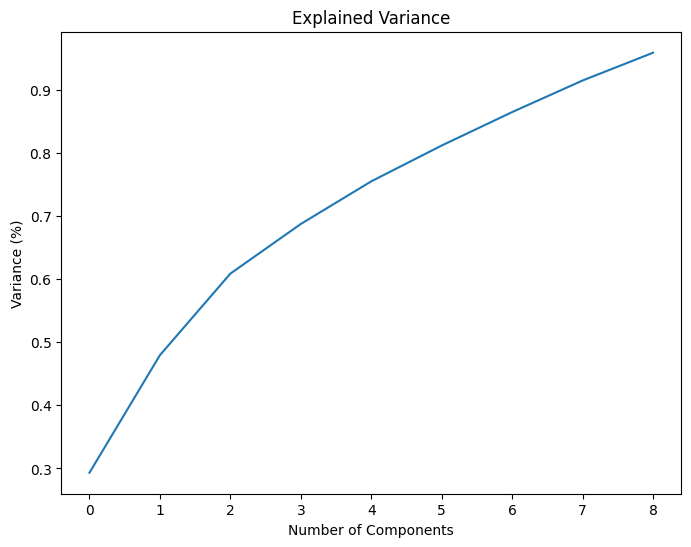

In [18]:
# PCA
pca = PCA(n_components=9)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

# Plot the PCA
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_pca[:,0], x_pca[:,1], c=numeric_classes, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

# Create a legend
classes = label_encoder.classes_
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(len(classes))]
plt.legend(handles, classes, title="Classes")
plt.title('PCA')

plt.show()

# Explained Variance
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

# Plot the explained variance
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

## (3-4) Model Training and Evaluation
- We wanted to try out a few different models to compare a few different things
- Mainly model speed and accuracy
- Some of these models take up to a minute where as the decision tree is almost instant.

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_pca, numeric_classes, test_size=0.3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 9)
(70000,)
(30000, 9)
(30000,)


### (3) Training Model (MLP Classifier)
- Multi-layered Perceptron Classifier

[[16742   285   760]
 [  511  5246    18]
 [ 1314    11  5113]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17787
           1       0.95      0.91      0.93      5775
           2       0.87      0.79      0.83      6438

    accuracy                           0.90     30000
   macro avg       0.91      0.88      0.89     30000
weighted avg       0.90      0.90      0.90     30000



<Figure size 800x600 with 0 Axes>

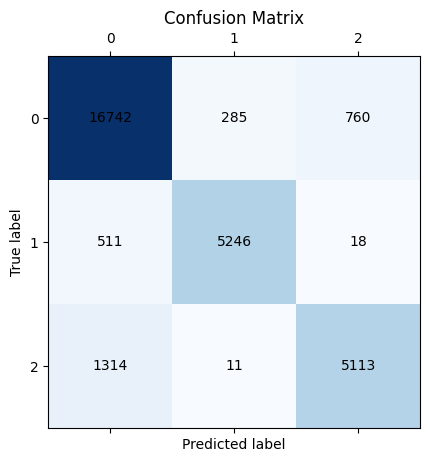

In [20]:
# neural network
from sklearn.neural_network import MLPClassifier

# Train the model
mlp = MLPClassifier(hidden_layer_sizes=(9,9,9), max_iter=1000)
mlp.fit(X_train, y_train)

# Predictions
predictions = mlp.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, predictions)
plt.matshow(cm, cmap='Blues')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### (4) Evaluate Model (MLP Classifier)

In [21]:
# Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print('Precision: %.2f' % precision)

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print('Recall: %.2f' % recall)

# F1
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 score: %.2f' % f1)

Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 score: 0.90


### (3) Training Model (Decision Tree)

[[15868   715  1204]
 [  740  4963    72]
 [ 1156    92  5190]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     17787
           1       0.86      0.86      0.86      5775
           2       0.80      0.81      0.80      6438

    accuracy                           0.87     30000
   macro avg       0.85      0.85      0.85     30000
weighted avg       0.87      0.87      0.87     30000



<Figure size 800x600 with 0 Axes>

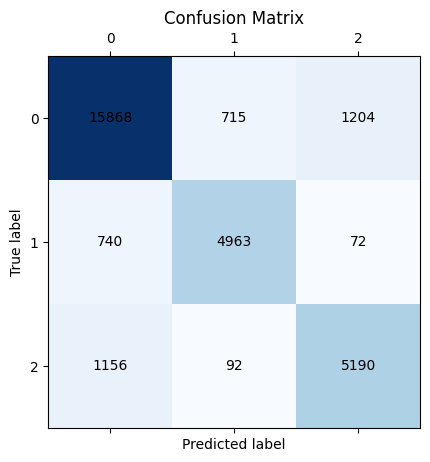

In [22]:
# decision tree
from sklearn import tree
# Train the model
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Predictions
predictions = clf.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, predictions)
plt.matshow(cm, cmap='Blues')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### (4) Evaluate Model (Decision Tree)

In [23]:
# Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print('Precision: %.2f' % precision)

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print('Recall: %.2f' % recall)

# F1
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 score: %.2f' % f1)

Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1 score: 0.87


### (3) Training Model (Support Vector Machine)

[[16708   161   918]
 [  889  4843    43]
 [ 1466     5  4967]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     17787
           1       0.97      0.84      0.90      5775
           2       0.84      0.77      0.80      6438

    accuracy                           0.88     30000
   macro avg       0.89      0.85      0.87     30000
weighted avg       0.89      0.88      0.88     30000



<Figure size 800x600 with 0 Axes>

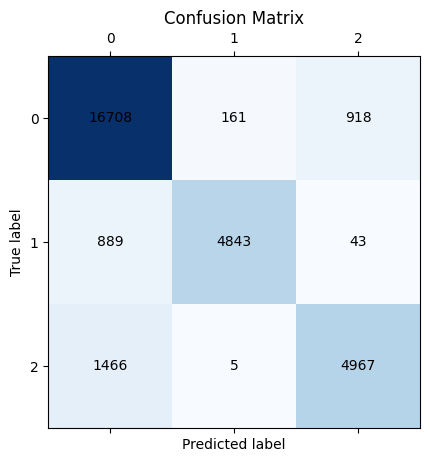

In [24]:
# support vector machine
from sklearn import svm
# Train the model
clf = svm.SVC()
clf.fit(X_train, y_train)

# Predictions
predictions = clf.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, predictions)
plt.matshow(cm, cmap='Blues')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### (4) Evaluate Model (Support Vector Machine)

In [25]:
# Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print('Precision: %.2f' % precision)

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print('Recall: %.2f' % recall)

# F1
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 score: %.2f' % f1)

Accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1 score: 0.88


### (4) Training Model (Sequential Model)
- Wanted to take a stab at building out a model of my own.
- Takes about 1m30s to run.
- Compares pretty well in accuracy to the other methods.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 18)                180       
                                                                 
 hidden2 (Dense)             (None, 18)                342       
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 hidden3 (Dense)             (None, 18)                342       
                                                                 
 output (Dense)              (None, 3)                 57        
                                                                 
Total params: 921 (3.60 KB)
Trainable params: 921 (3.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
2800/2800 - 8s 

<Figure size 800x600 with 0 Axes>

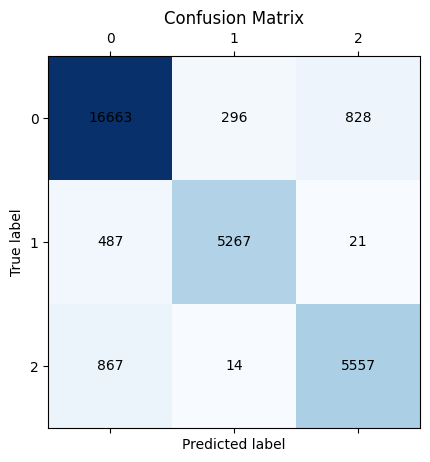

In [26]:
# sequential model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

# Create a Sequential model
model = Sequential()

model.add(Input(shape=(9,)))
model.add(Dense(18, activation='relu', name='hidden1'))
model.add(Dense(18, activation='relu', name='hidden2'))
model.add(Dropout(0.2))
model.add(Dense(18, activation='relu', name='hidden3'))
model.add(Dense(3, activation='softmax', name='output'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=20, verbose=2, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predictions
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

# Evaluate the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, predictions)
plt.matshow(cm, cmap='Blues')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


### (4) Evaluate Model (Sequential Model)

In [27]:
# Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print('Precision: %.2f' % precision)

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print('Recall: %.2f' % recall)

# F1
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 score: %.2f' % f1)

Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 score: 0.92


## (5) Lessons Learned



  # Stellar Dataset
  With our dataset for stellar classification, a lot of the contextual meaning of the data was lost. It may have been rewarding to use a dataset with a more clear meaning to our group. However, it is also valuable to observe that viable stellar classification models can be trained by people who otherwise have little to no astronomy experience. This proves that machine learning can be a powerful tool to easily create predictions that would have otherwise taken a significant amount of knowledge.
  # PCA
  Though as a concept, PCA is rather simple, effective implementation of PCA ended up as the bulk of the work on this project. The *Explained Variance by Different Principal Components* Graph was particularly interesting. It allowed us to visualize the effect of PCA on the data. After determining the ideal number of components, only a few lines were necessary to actually do the PCA.
  # Models
  Because of our previous experience in the AI class, training and evaluating models was an easy task. Becase of this, we thought it would be interesting to compare the performance of multiple different models, inluding SciKitLearn's Multi-layered Perceptron Classifier, Decision Tree Classifier, Support Vector Machine Classifier, and a Sequential Classifier of our own making. Each model chosen has it's pros and cons. For example, despite having slightly worse results than the other models, the decision tree took much less time to train. In the end, however it seems our own Sequential model, reached better, or at least comparable accuraccies to the SciKitLearn models. If we had more time, it may have been interesting to implement our own Decision Tree and Support Vector Machine alongside our Sequential model. This would have made for much more interesting comparisons between our models and SciKitLearn's.